In [1]:
from arrow import now
from catboost import CatBoostClassifier
from matplotlib.pyplot import plot
from numpy import unique
from pandas import get_dummies
from pandas import read_csv
from pandas import DataFrame
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [2]:
train_fname = '../input/titanic/train.csv'
train_df = read_csv(filepath_or_buffer=train_fname)
print('{}: train shape: {}'.format(now(), train_df.shape))

2022-12-19T19:13:56.458939+00:00: train shape: (891, 12)


In [3]:
# use a function to prepare our data so we can apply the same transformation to train and test
def prepare(input_df: DataFrame) -> DataFrame:
    # one-hot encoding for categorical columns Sex, Pclass, Embarked
    drop_columns = ['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin']
    drop_columns = [column for column in drop_columns if column in input_df.columns]
    result_df = get_dummies(data=input_df, columns=['Sex', 'Pclass', 'Embarked',]).drop(columns=drop_columns)
    # fill in median values 
    for column in ['Age', 'Fare']:
        result_df[column + 'Null'] = result_df[column].isnull().astype(int)
    median_age = input_df['Age'].dropna().median()
    median_fare = input_df['Fare'].dropna().median()
    result_df['Age'] = result_df['Age'].fillna(median_age)
    result_df['Fare'] = result_df['Fare'].fillna(median_fare)
    return result_df

def prepare_0(input_df: DataFrame) -> DataFrame:
    drop_columns = ['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin']
    drop_columns = [column for column in drop_columns if column in input_df.columns]
    result_df = input_df.drop(columns=drop_columns).copy(deep=True)
    for column in ['Sex', 'Pclass', 'Embarked',]:
        result_df[column] = LabelEncoder().fit_transform(y=result_df[column])

    # fill in median values 
    for column in ['Age', 'Fare']:
        result_df[column + 'Null'] = result_df[column].isnull().astype(int)
    median_age = input_df['Age'].dropna().median()
    median_fare = input_df['Fare'].dropna().median()
    result_df['Age'] = result_df['Age'].fillna(median_age)
    result_df['Fare'] = result_df['Fare'].fillna(median_fare)
    return result_df
    
    
prepared_df = prepare_0(input_df=train_df)

In [4]:
random_state = 1
model = CatBoostClassifier(
    iterations = 1000,
    learning_rate = 0.1,
    random_seed=random_state,
)
model.fit(X=prepared_df, y=train_df['Survived'])
# get the accuracy score
score = accuracy_score(y_true=train_df['Survived'], y_pred=model.predict(data=prepared_df))
print('{}: score: {:0.4f}'.format(now(), score))

0:	learn: 0.6278254	total: 58.4ms	remaining: 58.4s
1:	learn: 0.5841367	total: 60.4ms	remaining: 30.1s
2:	learn: 0.5509470	total: 61.8ms	remaining: 20.5s
3:	learn: 0.5210623	total: 63.2ms	remaining: 15.7s
4:	learn: 0.4968619	total: 64.7ms	remaining: 12.9s
5:	learn: 0.4792674	total: 66.2ms	remaining: 11s
6:	learn: 0.4587290	total: 67.7ms	remaining: 9.6s
7:	learn: 0.4491813	total: 69.9ms	remaining: 8.67s
8:	learn: 0.4336022	total: 72.5ms	remaining: 7.98s
9:	learn: 0.4265442	total: 75.9ms	remaining: 7.52s
10:	learn: 0.4184982	total: 78.4ms	remaining: 7.05s
11:	learn: 0.4125499	total: 79.7ms	remaining: 6.56s
12:	learn: 0.4058616	total: 80.9ms	remaining: 6.14s
13:	learn: 0.4016862	total: 82.2ms	remaining: 5.79s
14:	learn: 0.3993550	total: 83.1ms	remaining: 5.46s
15:	learn: 0.3964285	total: 84.1ms	remaining: 5.17s
16:	learn: 0.3916790	total: 85.5ms	remaining: 4.95s
17:	learn: 0.3887559	total: 87ms	remaining: 4.74s
18:	learn: 0.3841429	total: 88.3ms	remaining: 4.56s
19:	learn: 0.3822175	total:

{0: 553, 1: 338}

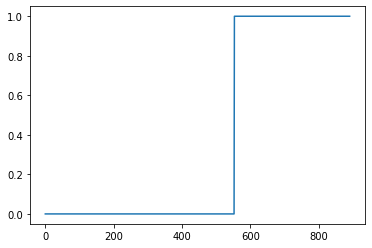

In [5]:
y_pred = model.predict(data=prepared_df)
plot(sorted(y_pred.tolist()), )
values, counts = unique(y_pred, return_counts=True)
dict(zip(values, counts))

In [6]:
# now predict
test_fname = '../input/titanic/test.csv'
test_df = read_csv(filepath_or_buffer=test_fname)
print('{}: test shape: {}'.format(now(), test_df.shape))
prepared_test_df = prepare_0(input_df=test_df)
test_df['Survived'] = model.predict(data=prepared_test_df)
result_columns = ['PassengerId', 'Survived']
result_fname = './submission.csv'
test_df[result_columns].to_csv(index=False, path_or_buf=result_fname,)
print('{}: wrote submission to {}'.format(now(), result_fname))
# trivial model is everyone dies - score 0.622
test_df['Trivial_Survived'] = 0

2022-12-19T19:13:58.433545+00:00: test shape: (418, 11)
2022-12-19T19:13:58.446141+00:00: wrote submission to ./submission.csv
